In [27]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PAIRS = ['ETH_BTC', 'ETH_USDT', 'BTC_USDT', 'ETH_USD', 'BTC_USD']
METHODS = ['oracle', 'naive', 'hawkes_5', 'hawkes_10', 'hawkes_15', 'hawkes_20', 'poisson_5', 'poisson_10', 'poisson_15', 'poisson_20',
           'movingaverage_30', 'movingaverage_60', 'movingaverage_120', 'movingaverage_180', 'movingaverage_240']

DATA_PATH_PREFIX = 'data_'
DATA_SUBSAMPLED_FOLDER = 'sampled_coe_dfs'

def get_coe_dfs_paths_for_pair_method(data_path_prefix, pair, data_subsampled_folder, method) -> List[str]:
    df_folder = os.path.join(data_path_prefix + pair, data_subsampled_folder, method)
    file_paths = [
        os.path.join(df_folder, f)
        for f
        in os.listdir(df_folder)
        if f.endswith('.csv')
    ]

    seen = dict()
    results = list()

    for path in file_paths:
        filename = os.path.basename(path)
        parts = filename.split('_')
        if len(parts) >= 3:
            key = parts[0] + '_' + parts[1]
            if key not in seen:
                seen[key] = True
                results.append(path)
    
    return results

def get_test_df(coe_df: pd.DataFrame) -> pd.DataFrame:
    return coe_df[coe_df['Timestamp'] > 1800]

def get_test_df_aggregated_for_pair_method(data_path_prefix, pair, data_subsampled_folder, method) -> pd.DataFrame:
    coe_dfs_paths = get_coe_dfs_paths_for_pair_method(data_path_prefix, pair, data_subsampled_folder, method)
    coe_dfs = [pd.read_csv(path) for path in coe_dfs_paths]
    for coe_df in coe_dfs:
        coe_df['Last'] = 0
        coe_df.loc[coe_df.index[-1], 'Last'] = 1
    test_dfs = [get_test_df(coe_df) for coe_df in coe_dfs]
    test_df = pd.concat(test_dfs)

    test_df['Method'] = method
    test_df['Pair'] = pair

    return test_df

def get_test_df_aggregated_for_pair(data_path_prefix, pair, data_subsampled_folder, methods) -> pd.DataFrame:
    test_dfs = [get_test_df_aggregated_for_pair_method(data_path_prefix, pair, data_subsampled_folder, method) for method in methods]
    return pd.concat(test_dfs)

def get_test_df_aggregated(data_path_prefix, data_subsampled_folder, pairs, methods) -> pd.DataFrame:
    test_dfs = [get_test_df_aggregated_for_pair(data_path_prefix, pair, data_subsampled_folder, methods) for pair in pairs]
    return pd.concat(test_dfs)

In [28]:
df = get_test_df_aggregated(DATA_PATH_PREFIX, DATA_SUBSAMPLED_FOLDER, PAIRS, METHODS)
df['ErrorForNearest'] = (df['NearestEventTimestampNotScaled'] - df['Timestamp']).abs()
df['ErrorForNext'] = (df['RealNextEventTimestampNotScaled'] - df['Timestamp']).abs()
df.head()

,Timestamp,BaseImbalance,Return,LastEventTimestampNotScaled,NearestEventTimestampNotScaled,RealNextEventTimestampNotScaled,Last,Method,Pair,ErrorForNearest,ErrorForNext
2801,1800.156,0.652174,-0.000686,1800.156,1800.156,1800.156,0,oracle,ETH_BTC,0.0,0.0
2802,1802.037,0.467456,0.000157,1802.037,1802.037,1802.037,0,oracle,ETH_BTC,0.0,0.0
2803,1803.049,0.123967,0.000010,1803.049,1803.049,1803.049,0,oracle,ETH_BTC,0.0,0.0
2804,1804.041,0.405797,0.000029,1804.041,1804.041,1804.041,0,oracle,ETH_BTC,0.0,0.0
2805,1805.134,0.333333,0.000029,1805.134,1805.134,1805.134,0,oracle,ETH_BTC,0.0,0.0


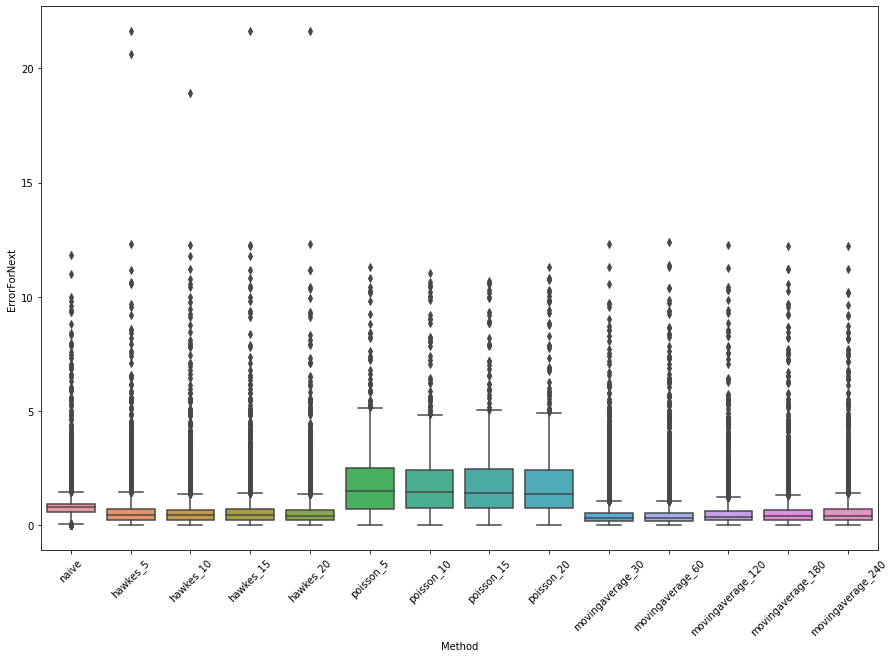

In [35]:
df_btc_usd = df[df['Pair'] == 'BTC_USDT']
df_btc_usd = df_btc_usd[df_btc_usd['Method'] != 'oracle']
df_btc_usd = df_btc_usd[df_btc_usd['Last'] == 0]
df_btc_usd = df_btc_usd[df_btc_usd['RealNextEventTimestampNotScaled'] < 1930]

# plot distribution of error for next event divided by method
plt.figure(figsize=(15, 10))
sns.boxplot(x='Method', y='ErrorForNext', data=df_btc_usd)
plt.xticks(rotation=45)
plt.show()


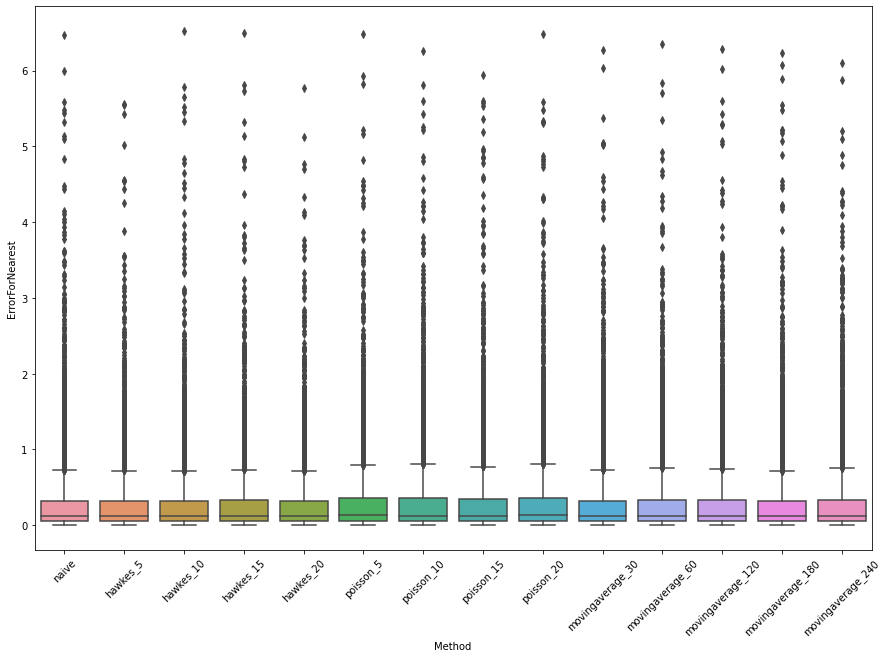

In [36]:
# plot distribution of error for next event divided by method
plt.figure(figsize=(15, 10))
sns.boxplot(x='Method', y='ErrorForNearest', data=df_btc_usd)
plt.xticks(rotation=45)
plt.show()
